# Proxy

In [1]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
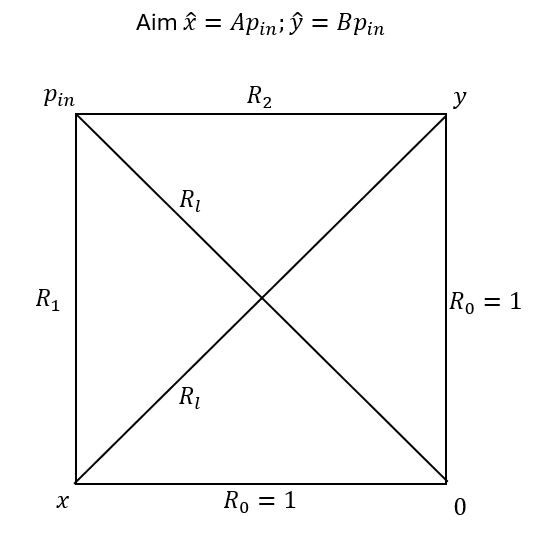
</div>


In [2]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 
        elif variabs.task_type == 'General_reg':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, \
            self.R4, self.R5, self.R6, self.p1, self.p2 = sp.symbols('x, y, z, R1, R2, R3, R4, R5, R6, p1, p2') 

class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        if self.variabs.task_type == 'Allostery':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
            self.loss_fn = loss_fn_allostery
        elif self.variabs.task_type == 'Regression':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
        elif self.variabs.task_type == 'General_reg':
            self.R_in_t = [np.array([1.,1.,1.,1.,1.,1.])]
            # self.R_in_t = [np.array([18.7,2.4,4.0,-13.5,-12.8,1.5])]
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
            
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
        elif self.variabs.task_type == 'General_reg':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2 + syms.p2**2 + syms.x**2 + syms.y**2 + syms.z**2 + (syms.p1-syms.p2)**2 + (syms.x-syms.y)**2 + \
                     (syms.y-syms.z)**2
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
        elif self.variabs.task_type == 'General_reg':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            dPdz = self.P.diff(syms.z)
            sols = sp.solve([dPdx,dPdy,dPdz],[syms.x,syms.y,syms.z])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
            self.z = sols[syms.z]
    
    def calc_output(self, syms):
        if self.variabs.task_type == 'Allostery':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        elif self.variabs.task_type == 'General_reg':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':     
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression' or self.variabs.task_type=='General_reg':
            p_drawn = self.p_drawn_in_t[-1]
            p_drawn_prev = self.p_drawn_in_t[-2]
#             p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1]))
#             print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1])))
            p_nxt = p - (p_drawn-p_drawn_prev)*np.dot(self.variabs.alpha, loss[0]-loss[1])
            print('the dot for p', np.dot(self.variabs.alpha, loss[0]-loss[1]))
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_dual = self.out_dual_in_t[-1]
        if self.variabs.task_type=='Allostery':
            self.output = out_dual + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg':
#             print('output', self.output)
#             print('output_prev', self.out_in_t[-2])
            # self.output = out_dual + self.variabs.alpha * np.dot(self.output-self.out_in_t[-2], loss[0]-loss[1])
            self.output = out_dual + self.variabs.alpha * (self.output-self.out_in_t[-2])*(loss[0]-loss[1])
        self.out_dual_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('dual output', self.output)
    
    def update_Rs(self):
        if self.variabs.task_type=='Allostery' or self.variabs.task_type=='Regression':
            self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        else:
            R_ij = []
            print(self.p_in_t[-1])
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            self.R_in_t.append(R_ij)
            # self.R_in_t.append(self.R_in_t[0])
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [63]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        print('alpha_vec', alpha_vec)
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    elif task_type=='General_reg':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec, alpha_vec))
        print(alpha_vec)
        gamma = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # how much resistance changed due to pressure difference
        A = 0.05
        B = 0.25
        C = 0.1
        D = 0.15
        E = 0.02
        F = 0.95
        M = np.array([[A, B],  
                      [C, D], 
                      [E, F]])  # this is in terms of M matrix, desired press. is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression' or task_type=='General_reg':              
                if task_type=='Regression' and np.size(alpha)>1 :
                    state.update_alpha(alpha(i))
                state.draw_p()
                if task_type=='Regression':
                    desired = np.dot(AB_vec, state.p_drawn)
                else:
                    desired = np.matmul(M, state.p_drawn)
                state.desired_in_t.append(desired)
                if supress:
                    pass
                else:
                    print('p_drawn', state.p_drawn)
                    print('desired', desired)
                state.calc_output(syms)
                if not i % 2:  # even iterations
                    pass
                else:
                    state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()              
                       
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired


def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'x desired', 'y deisred']
        legend2 = ['x dual', 'y dual', 'p dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = ['x', 'x desired']
        legend2 = ['x dual', 'p1 dual', 'p2 dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif task_type=='General_reg':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
#         C = desired[2]/state.p_in_t[0]  # B = y_hat/p_in
#         D = desired[3]/state.p_in_t[0]  # B = y_hat/p_in
#         E = desired[4]/state.p_in_t[0]  # B = y_hat/p_in
#         F = desired[5]/state.p_in_t[0]  # B = y_hat/p_in
        # R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'z', 'x desired', 'y deisred', 'z desired']
        legend2 = ['x dual', 'y dual', 'z dual', 'p1 dual', 'p2 dual']
        legend3 = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']
        R_theor = []  # I didn't calculate it for this task
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3.2))
    if variabs.task_type=='Allostery':
#         ax1.plot(state.out_in_t[1:], '.')
#         ax1.plot(np.outer(desired,np.ones(state.t)).T, '--')
        ax1.plot(state.out_in_t[1:]/desired-1)
    elif variabs.task_type=='Regression' or task_type=='General_reg':  # regression goes only every two samples
#         ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, state.out_in_t[1:])
#         ax1.plot(np.linspace(0, state.t, 2*state.t).T, state.desired_in_t, '--')
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, np.asarray(state.out_in_t[1:])/np.asarray(state.desired_in_t[1:])-1)
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_dual_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('dual and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    if variabs.task_type=='Allostery' or variabs.task_type=='Regression':  # loss is 2D in Allostery
        ax4.plot(np.abs(state.loss_in_t[1:]))
    elif task_type=='General_reg':    
        ax4.plot(np.mean(np.mean(np.abs(state.loss_in_t[1:]), axis=1),axis=1))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [64]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([1.0])
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
task_type = 'Regression'
# task_type = 'Allostery'
# task_type = 'General_reg'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=100

p_drawn [0.64358428 0.8547628 ]
desired 0.47112441017983303
output= 0.553486506211956
p_drawn [1.2008005  1.68193245]
desired 0.9008033127505901
output= 1.06487596669873
the dot for p -0.0817105579160164
loss= [-0.164072653948139 -0.0823620960321230]
time= 1
p_nxt= [1.04553044848460 1.06758849383983]
dual output [0.458214081871255]
R_nxt [0.587316366613348 0.609374411968573]
p_drawn [0.14723285 0.4909478 ]
desired 0.18163008959309115
output= 0.260775097613815
p_drawn [1.75555471 0.23686631]
desired 0.7614384604594913
output= 0.833865337277626
the dot for p 0.00671813120258921
loss= [-0.0724268768181344 -0.0791450080207236]
time= 2
p_nxt= [1.03472553125234 1.06929544658009]
dual output [0.462064177292240]
R_nxt [0.572661353960096 0.607231269287855]
p_drawn [0.76661571 0.81050158]
desired 0.5092716803633515
output= 0.652033049077078
p_drawn [0.2803221  1.48062149]
desired 0.4822842103234961
output= 0.714075618841939
the dot for p -0.0890300398047166
loss= [-0.231791408518443 -0.142761368

output= 0.560137654975086
p_drawn [1.90465946 1.03946412]
desired 1.021729816190349
output= 1.03033286101430
the dot for p 0.00499187208333263
loss= [-0.00860304482394869 -0.0135949169072813]
time= 35
p_nxt= [1.25658478757526 1.93871153075908]
dual output [0.0590546868434824]
R_nxt [1.19753010073178 1.87965684391559]
p_drawn [1.40969522 0.15449813]
desired 0.6025026194024871
output= 0.607164917951921
p_drawn [1.9873194  1.67501486]
desired 1.213681476012511
output= 1.22971701799536
the dot for p -0.0113732434334178
loss= [-0.0160355419828522 -0.00466229854943434]
time= 36
p_nxt= [1.26315424805798 1.95600473765706]
dual output [0.0519742502597028]
R_nxt [1.21117999779828 1.90403048739736]
p_drawn [1.29750871 1.9201268 ]
desired 0.9990351810692089
output= 1.01058372428079
p_drawn [1.31590759 0.9043898 ]
desired 0.7524604829400621
output= 0.758742809493574
the dot for p 0.00526621665806815
loss= [-0.00628232655351191 -0.0115485432115801]
time= 37
p_nxt= [1.26305735557087 1.96135382876741]

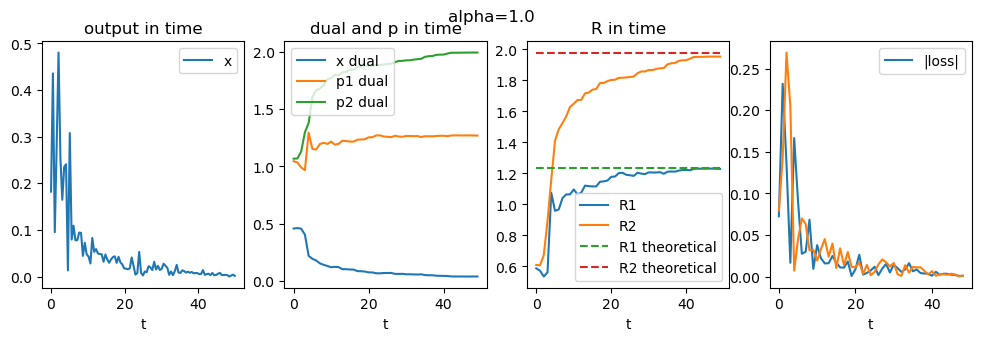

In [65]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0)

ValueError: x and y must have same first dimension, but have shapes (399,) and (199,)

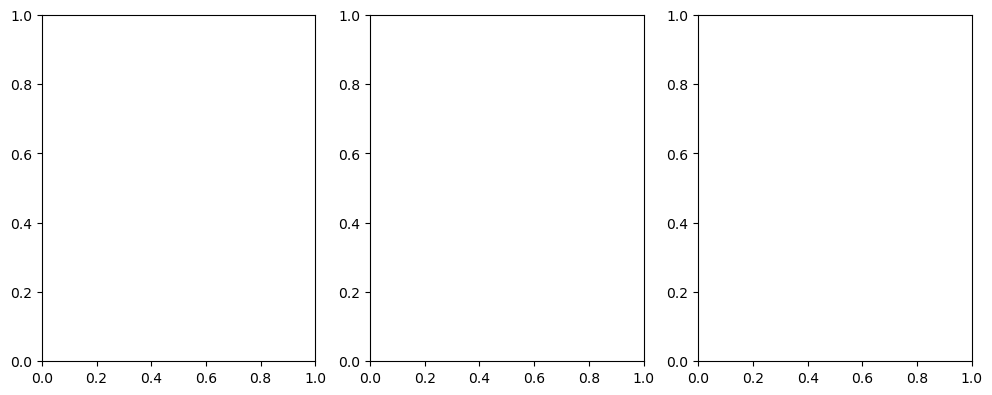

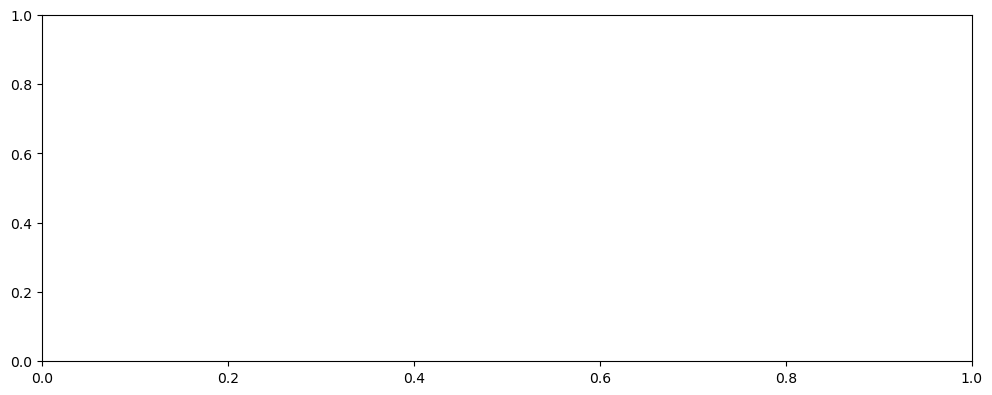

In [47]:
## This only works for "General Regression"

fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
legend1 = ['x', 'x desired']
if variabs.task_type=='Allostery' or variabs.task_type=='Regression':
    pass
elif task_type=='General_reg':  # regression goes only every two samples
    for i in range(3):
        axes[i].plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        axes[i].plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
        axes[i].legend(legend1)
        
for i in range(3):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
    plt.plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
    plt.plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
    plt.legend(legend1)

In [ ]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")

In [ ]:
state.desired_in_t
